## Campos involucrados

- direccion
- idzona
- ciudad
- provincia
- lat
- lng

## Objetivos

- Normalizar (provincia, ciudad, dirección)
- Agregar información (geometry)
- Métodos para graficar (cantidad+densidad)
- Método para definir si x publicación está en una geometry

- Agregar información externa (distrito electoral, etc.)


In [1]:
import pandas as pd
import geopandas
import matplotlib.pyplot as plt
from shapely.geometry import Point, Polygon

In [2]:
#importo las funciones para levantar los dataframes
%run "../../utils/dataset_parsing.ipynb"
#importo las funciones para graficar
%run "../../utils/graphs.ipynb"

In [3]:
pais = geopandas.read_file("./MEX_adm/MEX_adm0.shp")
estados = geopandas.read_file("./MEX_adm/MEX_adm1.shp")
municipios = geopandas.read_file("./MEX_adm/MEX_adm2.shp")
ciudades = geopandas.read_file("./México_Centros_Urbanos/México_Centros_Urbanos.shp")
mexico_polygon = pais.iloc[0]["geometry"]

In [17]:
df = levantar_datos("../../"+DATASET_RELATIVE_PATH)
df["tiene_gps"] = ~ (df["lat"].isna() & df["lng"].isna())
crear_punto = lambda x: Point(x["lng"],x["lat"]) if x["tiene_gps"] else None
df["coord"] = df.apply(crear_punto, axis=1)

In [5]:
def esta_en_mexico(point: Point) -> bool:
    """ 
        Recibe un punto (lat,lng) y devuelve (muy aproximadamente) True si está dentro de Mexico, False si no.
        Hacerlo con ```df["coord"].map(lambda x: mexico_polygon.contains(x))``` sería muy lento.
    """
    MEX_MIN_LNG, MEX_MAX_LNG = (-120, -85)
    MEX_MIN_LAT, MEX_MAX_LAT = (14,33)
    return (MEX_MIN_LNG < point.x < MEX_MAX_LNG) and (MEX_MIN_LAT < point.y < MEX_MAX_LAT)

In [19]:
df["en_mexico"] = df.loc[df["tiene_gps"]]["coord"].map(esta_en_mexico)

In [20]:
df["en_mexico"].value_counts()

True     115871
False       641
Name: en_mexico, dtype: int64

In [60]:
geoDF = geopandas.GeoDataFrame(df.loc[df["tiene_gps"] & df["en_mexico"]], geometry="coord")

In [11]:
def dibujar_mexico(puntos):
    grafico = pais.plot(figsize=(18,9))
    estados.plot(ax=grafico, color="white")
#     municipios.plot(ax=grafico, color="white")
    # ciudades.plot(ax=grafico, color="yellow")
    puntos.plot(ax=grafico, color="green")

In [79]:
def fix_provincias(df, provincias) -> bool:
    # le cambio los nombres a las siguientes provincias, para que coincidan con mi info geografica 
    provincias_mapper = {
        "Baja California Norte": "Baja California",
        "Edo. de México": "México",
        "San luis Potosí": "San Luis Potosí"
    }
    df["estado"] = df["provincia"].map(lambda x: provincias_mapper.get(x, x))
    return set(validos["provincia"].dropna().unique()) == set(provincias["NAME_1"]) #verifico

In [80]:
fix_provincias(geoDF, estados)

True

In [81]:
def buscar_provincia(punto: Point, provincias):
    """
        Devuelve en qué provincia de mexico se encuentra el punto.
    """
#     if not punto: return None
    for provincia, geometry in provincias[["NAME_1","geometry"]].values:
        if geometry.contains(punto): return provincia

# agrego las provincias faltantes
geoDF.loc[geoDF["estado"].isna(), "estado"] = geoDF.loc[geoDF["estado"].isna()]["coord"].map(lambda x: buscar_provincia(x, estados))

In [82]:
geoDF.loc[~geoDF["estado"].isna()].groupby(["estado"]).agg({"id":"count"})

,id
estado,
Aguascalientes,1093
Baja California,1695
Baja California Sur,1049
Campeche,135
Chiapas,461
Chihuahua,2029
Coahuila,1929
Colima,583
Distrito Federal,33367


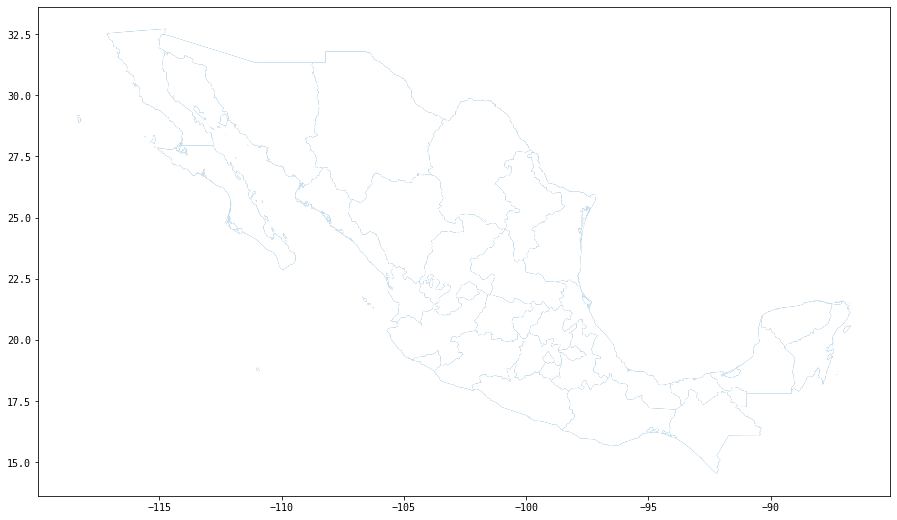

In [91]:
publicaciones_por_estado = geoDF.loc[~geoDF["estado"].isna()].groupby(["estado"]).agg({"estado":"count"})
grafico = pais.plot(figsize=(18,9))
estados.plot(ax=grafico, color="white", column= publicaciones_por_estado["estado"])

In [126]:
def choropleth_estados(estados, serie, nombre, titulo=""):
    estados[nombre] = estados["NAME_1"].map(serie)
    plot = estados.plot(column=nombre, legend=True, figsize=(24,8))    
    plot.set_title(titulo)
    return plot

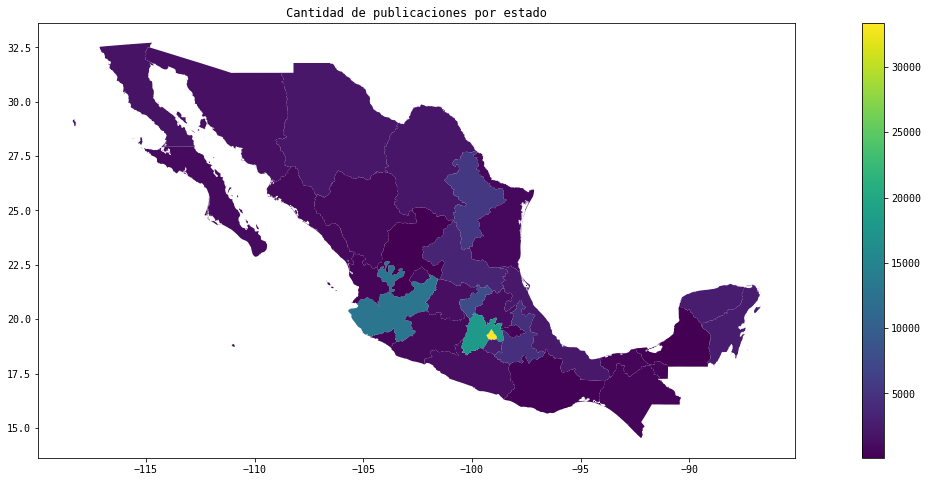

In [127]:
plot = choropleth_estados(estados, publicaciones_por_estado["estado"], "publicaciones", "Cantidad de publicaciones por estado")